In [1]:
#packages we need
using DifferentialEquations
using Plots 
using CSV
using Distributions
using Random
using DataFrames
using JLD2
using DelimitedFiles
using FileIO

### The following functions create dataframes and load saved results split into cycling and quiescent cells

In [2]:
function getCCtimes(mut_folder)
    CC_times_df = DataFrame(G1S=Int64[], SG2=Int64[], G2M=Int64[], M=Int64[], Cell=Int64[])

    for i in first_cell:last_cell
        if isfile("outputFiles_cell_cycle/"*mut_folder*"/plot_times/plot_times_"*string(i)*".csv") == true
            plot_times = DataFrame(CSV.File("outputFiles_cell_cycle/"*mut_folder*"/plot_times/plot_times_"*string(i)*".csv", header=true))
            plot_times[!, :Cell] = [i]
            append!(CC_times_df, plot_times)
        else
            continue
        end
    end
    return(CC_times_df)
end

getCCtimes (generic function with 1 method)

In [3]:
### Get plot times split into normal and quiescent cells

function getCCtimes_nq(mut_folder, q)
    CC_times_df = DataFrame(G1S=Int64[], SG2=Int64[], G2M=Int64[], M=Int64[], Cell=Int64[], State=String[], Plotn=Int64[], Plotq=Int64[])

    for i in first_cell:last_cell
        if isfile("outputFiles_cell_cycle/"*mut_folder*"/plot_times/plot_times_"*string(i)*".csv") == true
            plot_times = DataFrame(CSV.File("outputFiles_cell_cycle/"*mut_folder*"/plot_times/plot_times_"*string(i)*".csv", header=true))
            plot_times[!, :Cell] = [i]
            plot_times[!, :State] = ["n"]
            plot_times[!, :Plotn] = plot_times[!, :M]
            plot_times[!, :Plotq] = [0]                    
            append!(CC_times_df, plot_times)
        elseif isfile("outputFiles_cell_cycle/"*mut_folder*"/quiescent/sol_df"*string(i)*".csv") == true
            plot_times = DataFrame(G1S=1, SG2=2, G2M=3, M=q)
            plot_times[!, :Cell] = [i]
            plot_times[!, :State] = ["q"]
            plot_times[!, :Plotn] = [0]
            plot_times[!, :Plotq] = plot_times[!, :M]
            append!(CC_times_df, plot_times)
        else
            continue
        end
    end
    return(CC_times_df)
end

getCCtimes_nq (generic function with 1 method)

In [4]:
function getCCtimes_opt(mut_folder)
    CC_times_df = getCCtimes(mut_folder)
    sort!(CC_times_df, [:M])
    max_time = round(CC_times_df[nrow(CC_times_df), :M]*1.1, digits=0)
    CC_times_df2 = getCCtimes_nq(mut_folder, max_time)
    return(CC_times_df2)
end

getCCtimes_opt (generic function with 1 method)

### Import data

In [5]:
first_cell = 1
last_cell = 1000

1000

In [6]:
CC_times_WT = getCCtimes_opt("WT")

Row,G1S,SG2,G2M,M,Cell,State,Plotn,Plotq
,Int64,Int64,Int64,Int64,Int64,String,Int64,Int64
1,621,896,1004,1048,1,n,1048,0
2,365,653,765,824,2,n,824,0
3,711,997,1095,1136,3,n,1136,0
4,207,492,601,645,4,n,645,0
5,425,711,816,858,5,n,858,0
6,436,719,815,855,6,n,855,0
7,357,623,728,767,7,n,767,0
8,234,527,633,677,8,n,677,0
9,487,791,891,935,9,n,935,0


### Calculate parameter means and fold changes

In [7]:
### Get mean parameter value for cells in different groups

function groupRes(cells, mut_folder)
    df = vars
    for i in cells
        params = DataFrame(CSV.File("paramFiles/"*mut_folder*"/parameters_cell_"*string(i)*".csv"))
        params = params[params.distribute .== 1, :]
        params = params[:, Between(:parameter, :value)]
        rename!(params,:value => "cell_"*string(i))
        df = innerjoin(df, params, on = :parameter)
    end
    df = select(df, Not(:value))
    return(df)
end

groupRes (generic function with 1 method)

In [8]:
### Import parameters file and select parameters that are distributed

parameters_orig = DataFrame(CSV.File("parameters_plus_myc.csv"))
parameters_orig = parameters_orig[parameters_orig.distribute .== 1, :]
vars = parameters_orig[:, Between(:parameter, :value)]

Row,parameter,value
,String15,Float64
1,k1_10,0.0833333
2,k1_12,0.025
3,k1_13,0.0833333
4,k1_14,0.0416667
5,k1_2aa,0.0166667
6,k1_30,0.333333
7,k1_3a,0.125
8,k1_6a,0.166667
9,k1_8a,0.00166667


In [9]:
params_var = ["p27_cycD_Cdk2_deg", "Cdc20t_deg", "Cdc20_exp1", "Cdc20_deg1", "cycB_exp1b", "CycA_deg", "Cdh1_exp1", "p27.cycE/D/A.Cdk2_deg1", "p27.cycE.Cdk2_degp27_1", "Cdh1_deg", "CycB_exp", "CycA_exp", "p27_exp", "CycD_exp", "Cdc20t_exp", "CycE_exp"]

16-element Vector{String}:
 "p27_cycD_Cdk2_deg"
 "Cdc20t_deg"
 "Cdc20_exp1"
 "Cdc20_deg1"
 "cycB_exp1b"
 "CycA_deg"
 "Cdh1_exp1"
 "p27.cycE/D/A.Cdk2_deg1"
 "p27.cycE.Cdk2_degp27_1"
 "Cdh1_deg"
 "CycB_exp"
 "CycA_exp"
 "p27_exp"
 "CycD_exp"
 "Cdc20t_exp"
 "CycE_exp"

In [10]:
## select normal CC times
CC_times_WT_n = CC_times_WT[(CC_times_WT[!, :State].=="n"),:]
Cells_WTn = CC_times_WT_n[!, :Cell];

In [11]:
## select quiescent CC times
CC_times_WT_q = CC_times_WT[(CC_times_WT[!, :State].=="q"),:]
Cells_WTq = CC_times_WT_q[!, :Cell];

In [12]:
# WT q & n
WT_n = groupRes(Cells_WTn, "WT")
WT_q = groupRes(Cells_WTq, "WT")

Row,parameter,cell_12,cell_21,cell_31,cell_42,cell_95,cell_120,cell_130,cell_131,cell_159,cell_164,cell_169,cell_178,cell_193,cell_195,cell_200,cell_201,cell_206,cell_218,cell_238,cell_241,cell_259,cell_262,cell_278,cell_288,cell_290,cell_312,cell_334,cell_337,cell_348,cell_365,cell_389,cell_391,cell_393,cell_396,cell_407,cell_410,cell_417,cell_428,cell_444,cell_448,cell_462,cell_494,cell_511,cell_518,cell_537,cell_547,cell_559,cell_567,cell_617,cell_620,cell_632,cell_636,cell_647,cell_653,cell_679,cell_689,cell_699,cell_715,cell_726,cell_748,cell_750,cell_759,cell_762,cell_777,cell_785,cell_802,cell_806,cell_807,cell_837,cell_844,cell_856,cell_863,cell_869,cell_881,cell_882,cell_903,cell_905,cell_915,cell_917,cell_922,cell_959
,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,k1_10,0.0767561,0.0618021,0.0881275,0.0612417,0.0685346,0.0793795,0.072481,0.0891469,0.0727406,0.0587308,0.0770673,0.0874894,0.0767035,0.0803458,0.0795904,0.087338,0.0843357,0.0706113,0.0887605,0.0754415,0.0663169,0.0766725,0.0775046,0.0797904,0.0919409,0.0691856,0.0687597,0.0866287,0.0628354,0.062229,0.0708558,0.0804236,0.065076,0.0808529,0.0710874,0.0780348,0.0870949,0.0711012,0.0786214,0.0622829,0.0685742,0.0763582,0.0668395,0.0803475,0.0684006,0.089625,0.0497403,0.08397,0.0766662,0.0747546,0.0646081,0.0723112,0.0719796,0.0794716,0.0641058,0.0510893,0.0716943,0.0843887,0.0808685,0.0957255,0.0732069,0.0840468,0.0746564,0.0890659,0.0749801,0.0897685,0.0886684,0.0773974,0.0821979,0.0844178,0.0825221,0.0787913,0.0982256,0.0827797,0.0725582,0.0718562,0.0905478,0.0887502,0.0730132,0.0727953,0.0814886
2,k1_12,0.0202727,0.0259863,0.0244841,0.0229711,0.0191576,0.0235416,0.0249168,0.0269761,0.0245728,0.0259367,0.0186798,0.0234678,0.0280279,0.02685,0.0209646,0.0295363,0.0253131,0.0228066,0.0251377,0.0261668,0.0211994,0.0231536,0.0289304,0.0206399,0.0273763,0.0236748,0.0196411,0.0267541,0.0229462,0.0252822,0.0312656,0.0221074,0.0249972,0.0263133,0.0278389,0.0282879,0.018802,0.0245015,0.0269874,0.0267687,0.0271389,0.0282918,0.0207797,0.027174,0.0263105,0.02948,0.0289168,0.0291594,0.0245378,0.0251313,0.0257459,0.0274974,0.0222001,0.0208306,0.0195321,0.0261177,0.0247415,0.0257548,0.021323,0.0214275,0.0231794,0.0263282,0.024713,0.0283067,0.0244085,0.0276313,0.0279837,0.0229412,0.0275242,0.0289823,0.0240405,0.0164412,0.0310612,0.0304543,0.0269653,0.0247798,0.025198,0.0286832,0.0260293,0.0235378,0.0256181
3,k1_13,0.0801684,0.087812,0.0766219,0.0814193,0.0979726,0.0891809,0.0758349,0.0818075,0.077373,0.0858247,0.0799308,0.089133,0.0836865,0.0951079,0.0899755,0.0742748,0.0724839,0.0852094,0.0783716,0.0905506,0.0837289,0.0798552,0.0921017,0.092993,0.0861065,0.0941534,0.0952515,0.0773549,0.0658095,0.0950898,0.0930612,0.0881086,0.0794032,0.0854421,0.0624099,0.0784092,0.0745232,0.0724871,0.0977322,0.0792053,0.0860601,0.0862413,0.0857303,0.0802081,0.0871986,0.0978344,0.0778561,0.0787132,0.099385,0.0844712,0.0795114,0.0900988,0.0893696,0.0719087,0.0982491,0.0889244,0.0647707,0.0827348,0.0907103,0.091867,0.0968759,0.0970648,0.0844254,0.0962636,0.0957618,0.0896068,0.0762844,0.106162,0.0790617,0.0884456,0.0869437,0.0919827,0.0785998,0.0763629,0.0626098,0.0845066,0.0785087,0.0790391,0.0990407,0.0751384,0.0908178
4,k1_14,0.0373857,0.042394,0.0474994,0.0414143,0.0458122,0.037297,0.0411285,0.038745,0.0453035,0.0362615,0.0417541,0.0403358,0.0403143,0.0355169,0.0412775,0.0449318,0.034900

In [13]:
# WT cell groups
WTn_mean = mean.(eachrow(WT_n[!, 2:ncol(WT_n)]))
WTq_mean = mean.(eachrow(WT_q[!, 2:ncol(WT_q)]))

16-element Vector{Float64}:
 0.07663174519327563
 0.025063362195932082
 0.08483099172871707
 0.04061866984834478
 0.016841210769791535
 0.3401327276856223
 0.11348877215706853
 0.1764609072111782
 0.0016716486503643724
 0.009726595485643795
 0.0017442408812476337
 0.0009046228585481552
 0.3061956370574793
 0.04404715671544795
 0.02500484148235071
 0.010613911975545601

In [14]:
WT_means = DataFrame(n_mean = WTn_mean, q_mean = WTq_mean)

Row,n_mean,q_mean
,Float64,Float64
1,0.0838378,0.0766317
2,0.0250143,0.0250634
3,0.0834604,0.084831
4,0.0414976,0.0406187
5,0.0166846,0.0168412
6,0.334781,0.340133
7,0.12655,0.113489
8,0.165202,0.176461
9,0.00166893,0.00167165


### Get original parameters

In [15]:
parameters_orig = DataFrame(CSV.File("parameters_plus_myc.csv"))
parameters_orig = parameters_orig[parameters_orig.distribute .== 1, :]

Row,parameter,value,distribute
,String15,Float64,Int64
1,k1_10,0.0833333,1
2,k1_12,0.025,1
3,k1_13,0.0833333,1
4,k1_14,0.0416667,1
5,k1_2aa,0.0166667,1
6,k1_30,0.333333,1
7,k1_3a,0.125,1
8,k1_6a,0.166667,1
9,k1_8a,0.00166667,1


In [16]:
WT_means[!, :params] = params_var
WT_means[!, :orig] = parameters_orig[!, :value];

In [17]:
WT_means_FC = deepcopy(WT_means)
WT_means_FC[!, :diff_n] = WT_means_FC[!, :orig] ./ WT_means_FC[!, :n_mean]
WT_means_FC[!, :diff_q] = WT_means_FC[!, :orig] ./ WT_means_FC[!, :q_mean]

16-element Vector{Float64}:
 1.0874518489670573
 0.9974719195518642
 0.982345382292518
 1.025800873233123
 0.9896359132263448
 0.9800095841059234
 1.1014305435166742
 0.9444962605827646
 0.997019917813898
 1.0281089631783025
 0.9555257062934186
 0.9211938346742978
 1.0886286173222852
 0.9459558824460268
 0.9998063782026322
 0.9421596884390929

### Plotting

In [18]:
using StatsPlots

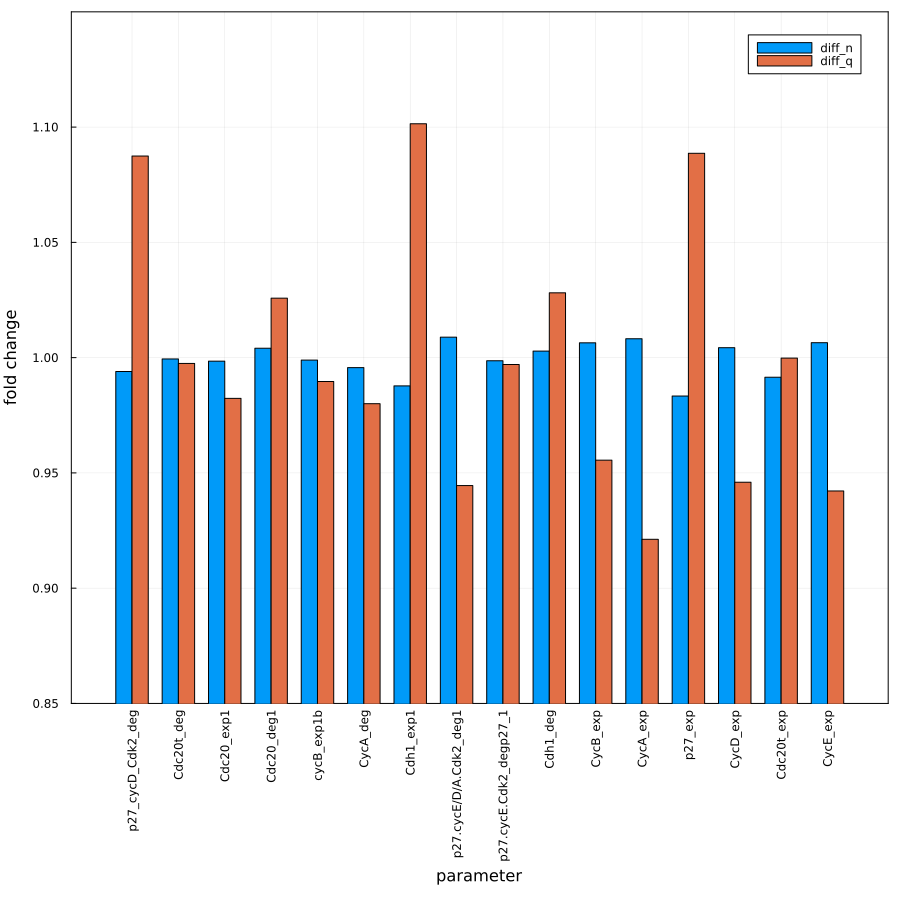

In [25]:
@df WT_means_FC groupedbar(:params, cols(5:6), 
                                        xrotation=90,
                                        ylims=(0.85,1.15), 
                                        size=(900,900),
                                        framestyle=:box,
                                        bar_width = 0.7,
                                        ylabel="fold change",
                                        xlabel="parameter",
                                        legend=:topright)